# Projet : Physique des matériaux
## Louis Noirot
###### LMAPR1492

In [181]:
import numpy as np

from mp_api.client import MPRester

from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from pymatgen.analysis.structure_matcher import StructureMatcher
from pymatgen.io.cif import CifWriter
from pymatgen.electronic_structure.core import Spin
from pymatgen.analysis.diffraction.xrd import XRDCalculator

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

from jupyter_jsmol.pymatgen import quick_view
from jupyter_jsmol import JsmolView
from ipywidgets import Layout, widgets, interact
from IPython.display import display

In [182]:
mp_key = "g2nCFD5rMkPRt9qdpOGhbfHJf2mgbv5x"
mp_id = "mp-14116"

In [183]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
    structure = m.get_structure_by_material_id(mp_id)
    band = m.get_bandstructure_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [184]:
# Exporter en CIF avec symétries
writer = CifWriter(conv_struc, symprec=0.01)
writer.write_file("data/CuRhO2_fixed.cif")

# Tâche 4 :  
#### Détermination des vecteurs de bases, des réseaux direct et réciproque, du type type de maille, du système cristallin, ainsi que le groupe ponctuel du matérieau.

In [185]:
# Calcul des vecteurs de base du réseau direct et réciproque
direct_lattice = conv_struc.lattice
reciprocal_lattice = direct_lattice.reciprocal_lattice

# Analyse de la symétrie
sga = SpacegroupAnalyzer(conv_struc)
crystal_system = sga.get_crystal_system()
lattice_type = sga.get_lattice_type()
point_group = sga.get_point_group_symbol()

# Affichage des résultats
print("* Vecteurs de base du réseau direct :")
print(direct_lattice)

print("\n* Vecteurs de base du réseau réciproque :")
print(reciprocal_lattice)

print("\n* Type de maille :", lattice_type)
print("* Système cristallin :", crystal_system)
print("* Groupe ponctuel :", point_group)

* Vecteurs de base du réseau direct :
1.542955 -2.672476 0.000000
1.542955 2.672476 0.000000
0.000000 0.000000 17.065340

* Vecteurs de base du réseau réciproque :
2.036089 -1.175537 0.000000
2.036089 1.175537 0.000000
0.000000 0.000000 0.368184

* Type de maille : rhombohedral
* Système cristallin : trigonal
* Groupe ponctuel : -3m


# Tâche 5 :
#### Étude de l’effet de 3 éléments de symétrie différents (pas l’identité) chacun pour 1 atome différent.

## Symétries : nombre total, sélection de 3 et determination du type:

In [186]:
# Détermination du nombre total de symmétries et sélection de trois symétries:

# Obtenir les opérations de symétrie
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

# Nombre de symétries disponibles
print("* Symétries disponibles :", len(symmops))


indices = [5, 10, 25]
for idx in indices:
    op = symmops[idx]
    mat = op.rotation_matrix
    det = np.linalg.det(op.rotation_matrix)     # Car si det > 0 -> rotation ou identité
                                                #  et si det < 0 -> réflexion ou roto-inversion
        
    trace = np.trace(op.rotation_matrix)        # Car si trace = -3 -> inversion pure
                                                #  et si trace =  3 -> identité

    # Détermination du type de symétrie
    if np.allclose(mat, np.eye(3)):
        sym_type = "Identité"
        
    elif np.allclose(mat, -np.eye(3)):
        sym_type = "Inversion pure"
    
    elif det > 0:
        angle = np.arccos((trace-1)/2)*180/np.pi
        axis = np.array([
            mat[2,1]-mat[1,2],
            mat[0,2]-mat[2,0],
            mat[1,0]-mat[0,1]])
        axis = axis/np.linalg.norm(axis) if np.linalg.norm(axis) != 0 else "[indéfini]"
        sym_type = f"Rotation pure de {angle:.1f}° autour de l'axe {axis}"
    
    else:
        # Si la matrice au carré est égale à l'identité -> réflexion pure
        if np.allclose(np.dot(mat, mat), np.eye(3)):
            sym_type = "Réflexion pure"
        else:
            angle = np.arccos((trace+1)/2)*180/np.pi
            sym_type = f"Roto-inversion de {angle:.1f}°"

    # Affichage
    print(f"\n* Symétrie {idx} : {sym_type}")
    print("  Matrice de rotation :\n", mat)
    print("  Vecteur de translation :", op.translation_vector)

* Symétries disponibles : 36

* Symétrie 5 : Roto-inversion de 60.0°
  Matrice de rotation :
 [[ 1. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0. -1.]]
  Vecteur de translation : [0. 0. 0.]

* Symétrie 10 : Rotation pure de 180.0° autour de l'axe [ 0.  0. -1.]
  Matrice de rotation :
 [[-1.  0.  0.]
 [-1.  1.  0.]
 [ 0.  0. -1.]]
  Vecteur de translation : [0. 0. 0.]

* Symétrie 25 : Inversion pure
  Matrice de rotation :
 [[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
  Vecteur de translation : [0.33333333 0.66666667 0.66666667]


## Sélection de trois éléments différents:

In [187]:
# Permet de voir la position des différents atomes dans la structure
print("* Voici la position des différens atomes dans la structure:")
for i, site in enumerate(conv_struc):
    print(f"   Atome {i} : {site.species_string}, position {site.frac_coords}")
    
# Sélection de 3 atomes spécifiques
atoms = [1, 4, 10]  # Indices des atomes sélectionés
atom_name = ["Cu", "Rh", "O"]


# Sélectionner 3 opérations de symétrie différentes
sym_op1 = symmops[5]
sym_op2 = symmops[10]
sym_op3 = symmops[25]

# Positions initiales
positions = [
    conv_struc[atoms[0]].frac_coords,
    conv_struc[atoms[1]].frac_coords,
    conv_struc[atoms[2]].frac_coords
]

# Aplication des transformations aux atomes sélectionnés
transformed_positions = [
    sym_op1.operate(conv_struc[atoms[0]].frac_coords),
    sym_op2.operate(conv_struc[atoms[1]].frac_coords),
    sym_op3.operate(conv_struc[atoms[2]].frac_coords),
]

# Afficher les anciennes et nouvelles positions des atomes transformés

print("\n\n * Position originale et transformée des différents atomes sélectionnés:")
for i in range(len(positions)):
    print(f"   Atome {atom_name[i]}: {positions[i]} -> {transformed_positions[i]}")

* Voici la position des différens atomes dans la structure:
   Atome 0 : Cu, position [0. 0. 0.]
   Atome 1 : Cu, position [0.66666667 0.33333333 0.33333333]
   Atome 2 : Cu, position [0.33333333 0.66666667 0.66666667]
   Atome 3 : Rh, position [0.33333333 0.66666667 0.16666667]
   Atome 4 : Rh, position [1.  1.  0.5]
   Atome 5 : Rh, position [0.66666667 0.33333333 0.83333333]
   Atome 6 : O, position [0.66666667 0.33333333 0.22617433]
   Atome 7 : O, position [0.       0.       0.107159]
   Atome 8 : O, position [0.33333333 0.66666667 0.55950767]
   Atome 9 : O, position [0.66666667 0.33333333 0.44049233]
   Atome 10 : O, position [0.       0.       0.892841]
   Atome 11 : O, position [0.33333333 0.66666667 0.77382567]


 * Position originale et transformée des différents atomes sélectionnés:
   Atome Cu: [0.66666667 0.33333333 0.33333333] -> [ 0.33333333  0.66666667 -0.33333333]
   Atome Rh: [1.  1.  0.5] -> [-1.00000000e+00 -1.11022302e-16 -5.00000000e-01]
   Atome O: [0.       0. 

## 0. La structure:

In [188]:
view = JsmolView(layout=Layout(height="600px"))
display(view)
view.load_file('data/CuRhO2_fixed.cif', '{1 1 1}', inline=True)
# view from right
view.script('moveto 0 0 1 0 90 200;')
view.script('rotate on')

JsmolView(layout=Layout(height='600px'))

## 1. La roto-inversion de 60° en fonction du Cu:

In [189]:
view1 = JsmolView(layout=Layout(height="600px"))
display(view1)
view1.load_file('data/CuRhO2_fixed.cif', '{1 1 1}', inline=True)
view1.script('draw SYMOP 5 {atomno=6}; select atomno=6; color yellow; label on')
view1.script('moveto 0.6 0.6 1 -0.1 210 300;')

JsmolView(layout=Layout(height='600px'))

## 2. La rotation pure de 180.0° autour de l'axe [0. 0. -1.] en fonction du Rh:

In [190]:
view2 = JsmolView(layout=Layout(height="600px"))
display(view2)
view2.load_file('data/CuRhO2_fixed.cif', '{1 1 1}', inline=True)
view2.script('draw SYMOP 10 {atomno=2}; select atomno=2; color yellow; label on')
view2.script('moveto 0.6 0.6 0.6 0 30 250;')

JsmolView(layout=Layout(height='600px'))

## 3. L'inversion pure avec un vecteur de translation non nul en function de l'O:

In [191]:
view3 = JsmolView(layout=Layout(height="600px"))
display(view3)
view3.load_file('data/CuRhO2_fixed.cif', '{1 1 1}', inline=True)
view3.script('draw SYMOP 25 {atomno=5}; select atomno=5; color yellow; label on')
view3.script('moveto 0.6 0.6 -0.6 0 -45 300;')

JsmolView(layout=Layout(height='600px'))

# Tâche 6 :
#### Déterminer les 3 premiers pics du diffractogramme correspondant (en indiquant les indices hkl associés) pour un rayonnement X incident Cu Kα de longueur d’onde λ=1.54060 Å.

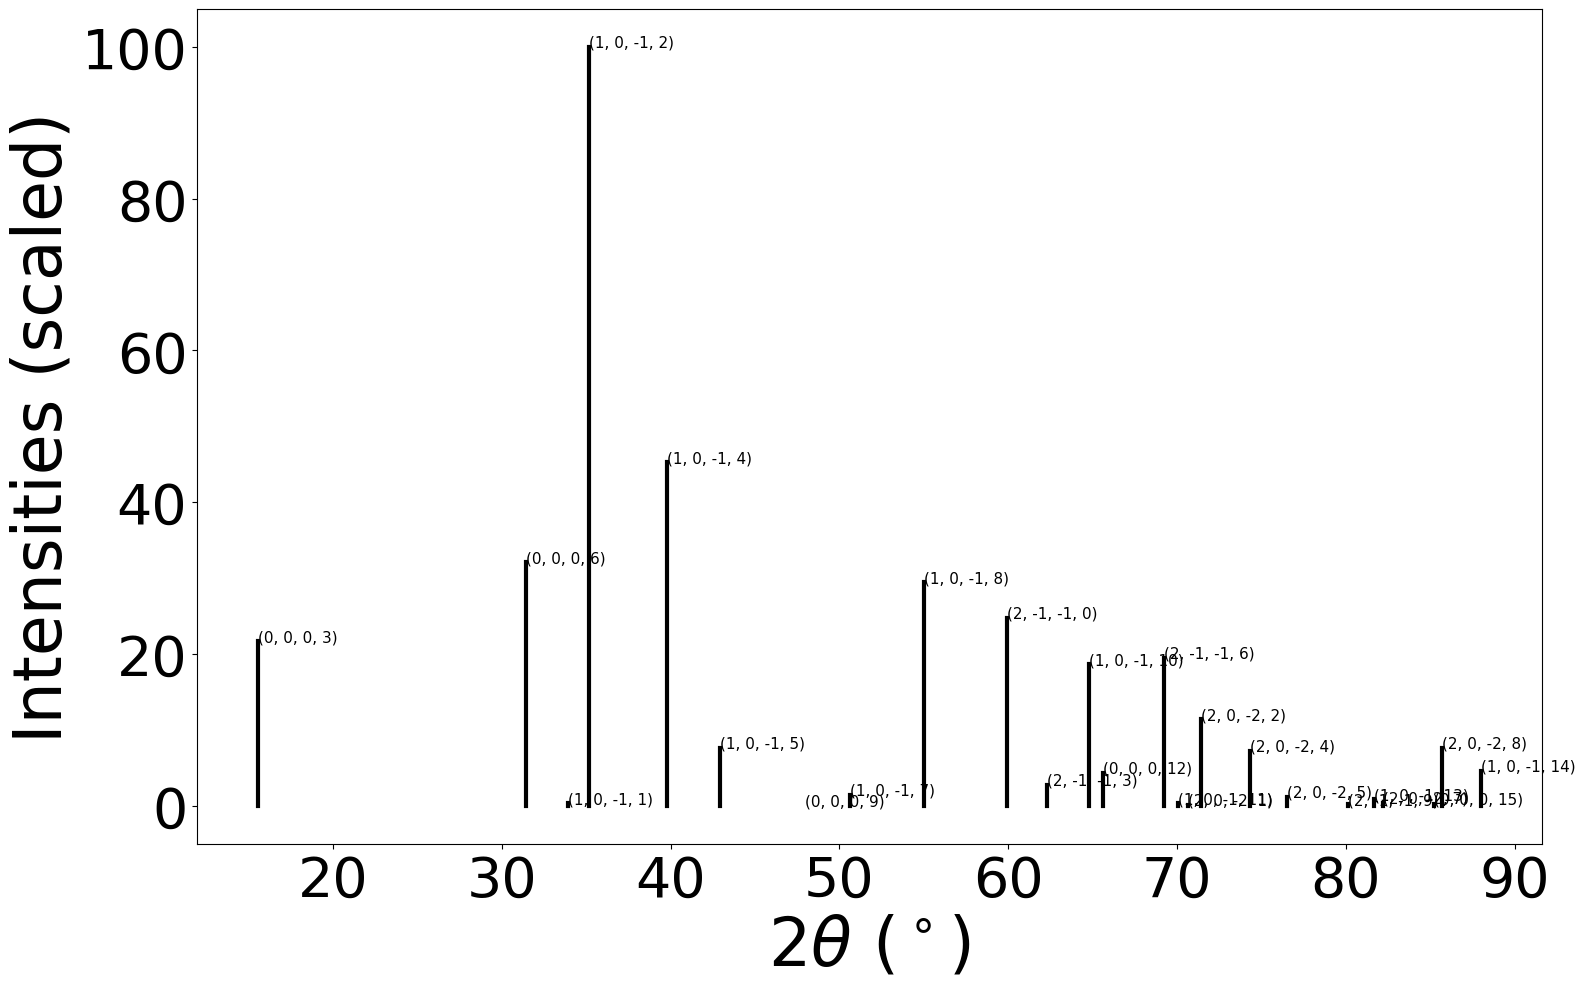

In [192]:
xrd = XRDCalculator(wavelength = 1.54060)  # rayonnement X incident Cu Kα de longueur d’onde λ=1.54060 Å.
xrd.get_plot(conv_struc, annotate_peaks='full', fontsize=11)
pattern = xrd.get_pattern(conv_struc)

In [193]:
for i in range(3):
    theta2 = pattern.x[i]
    intensity = pattern.y[i]
    indices_hkl = pattern.hkls[i][0].get("hkl")
    multiplicity = pattern.hkls[i][0].get("multiplicity")
    print("* Pic numéro " + str(i+1) +":")
    print(" - L'angle 2θ vaut: " + str(theta2) +"°")
    print(" - L'intensité relative de ce pic (sur une échelle de 0 à 100) est de: " +str(intensity))
    print(" - Les indices (h,k,l) sont " + str(indices_hkl) +"  et de multiplicité " + str(multiplicity) +"\n\n")

* Pic numéro 1:
 - L'angle 2θ vaut: 15.565215697861834°
 - L'intensité relative de ce pic (sur une échelle de 0 à 100) est de: 21.668350223294134
 - Les indices (h,k,l) sont (0, 0, 0, 3)  et de multiplicité 2


* Pic numéro 2:
 - L'angle 2θ vaut: 31.42728348308207°
 - L'intensité relative de ce pic (sur une échelle de 0 à 100) est de: 32.118210806657736
 - Les indices (h,k,l) sont (0, 0, 0, 6)  et de multiplicité 2


* Pic numéro 3:
 - L'angle 2θ vaut: 33.925222287826905°
 - L'intensité relative de ce pic (sur une échelle de 0 à 100) est de: 0.32186718097014516
 - Les indices (h,k,l) sont (1, 0, -1, 1)  et de multiplicité 12




# Tâche 7:
#### 1) Trouver la direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion (insérer une figure indiquant la dispersion par des flèches)
#### 2) calculer la masse effective au sommet (base) de la dernière (première) bande de valence (conduction) en supposant une dispersion parabolique.

## Bande interdite: 

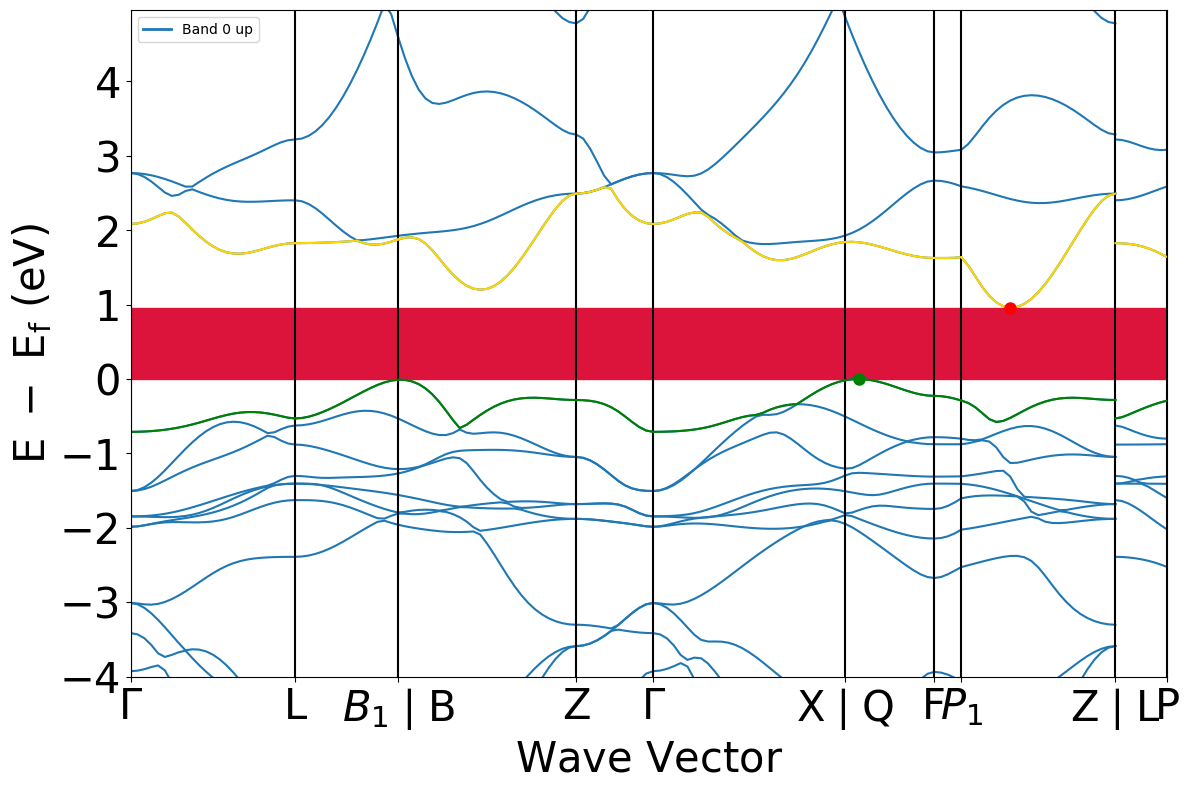

La largeur de la bande interdite est de: 0.9581 eV
La bande interdite de ce matériau est indirect
La transistion est en: (0.634,0.366,0.000)-(0.608,0.608,0.284)


In [194]:
bs_plot_data = BSPlotter(el_bs).bs_plot_data()
distance = bs_plot_data.get('ticks').get('distance')
distances = bs_plot_data.get('distances')
energy = bs_plot_data.get('energy')


vbm_band_index = el_bs.get_vbm()['band_index'][Spin.up][-1]  # Bande de valence n°1
cbm_band_index = el_bs.get_cbm()['band_index'][Spin.up][0]   # Bande de conduction n°1


BSPlotter(el_bs).get_plot()


for i in range(len(distances)):
    plt.plot(distances[i], energy.get('1')[i][vbm_band_index], 'green') 
    plt.plot(distances[i], energy.get('1')[i][cbm_band_index], 'gold') 


cbm_coord = bs_plot_data.get('cbm')
for (x, y) in cbm_coord:
    plt.plot(x, y, 'or', markersize=8)  


vbm_coord = bs_plot_data.get('vbm')
for (x, y) in vbm_coord:
    plt.plot(x, y, 'og', markersize=8)  


plt.fill_between(np.linspace(distance[0], distance[-1], 2), 0, el_bs.get_band_gap().get('energy'), color = "crimson")

plt.show()

print("La largeur de la bande interdite est de:", band_gap["energy"],"eV")
if band_gap["direct"] is True:
    print("La bande interdite de ce matériau est direct")
if band_gap["direct"] is False:
    print("La bande interdite de ce matériau est indirect")
print("La transistion est en:", band_gap["transition"])

In [195]:
bsplot = BSPlotter(el_bs)
bsdata = bsplot.bs_plot_data()

vbm = el_bs.get_vbm()
cbm = el_bs.get_cbm()


indices_vbm = list(vbm["band_index"].get(Spin.up, []))  
indices_cbm = list(cbm["band_index"].get(Spin.up, []))  


kpoint_vbm = vbm["kpoint"].cart_coords
kpoint_cbm = cbm["kpoint"].cart_coords


print("\n* Dernière bande de valence :")
print(" - Énergie du maximum de la bande de valence = {:.2f} eV".format(vbm["energy"]))
print(" - Vecteur k en coordonnées cartésiennes =", kpoint_vbm)
print(" - Indices des bandes de valence :", indices_vbm)

print("\n* Première bande de conduction :")
print(" - Énergie minimum de la bande de conduction = {:.2f} eV".format(cbm["energy"]))
print(" - Vecteur k en coordonnées cartésiennes =", kpoint_cbm)
print(" - Indices des bandes de conduction :", indices_cbm)


* Dernière bande de valence :
 - Énergie du maximum de la bande de valence = 4.14 eV
 - Vecteur k en coordonnées cartésiennes = [ 0.54246208 -0.53688287 -1.08547671]
 - Indices des bandes de valence : [21]

* Première bande de conduction :
 - Énergie minimum de la bande de conduction = 5.10 eV
 - Vecteur k en coordonnées cartésiennes = [ 0.65957477  0.         -0.65425884]
 - Indices des bandes de conduction : [22]


In [196]:
x = np.unique(bsdata["ticks"]["distance"])  
y = bsdata["energy"]

n = len(x)-1

dx = np.zeros(n)
dyc = np.zeros(n)
dyv = np.zeros(n)
mc = np.zeros(n)
mv = np.zeros(n)

for i in range(n):
    dx[i] = x[i+1] - x[i]
    
for i in range(n):
    dyv[i] =y.get('1')[i][21][-1] - y.get('1')[i][21][0]
    dyc[i] =y.get('1')[i][22][-1] - y.get('1')[i][22][0]
    
for i in range (n):
    mc[i] = dyc[i]/dx[i]
    mv[i] = dyv[i]/dx[i] 
    

valence_max = np.max(abs(mv))
indice_valance_max = np.argmax(abs(mv))
valence_min = np.min(abs(mv))
indice_valance_min = np.argmin(abs(mv))
conduction_max = np.max(abs(mc))
indice_conduction_max = np.argmax(abs(mc))
conduction_min = np.min(abs(mc))
indice_conduction_min = np.argmin(abs(mc))

print("* Dernière bande de valance :")
print(f" - La plus grande dispersion (en valeur absolue) est de : {valence_max} et est d'indice {indice_valance_max}.")
print(f" - La plus petite dispersion (en valeur absolue) est de : {valence_min} et est d'indice {indice_valance_min}.")

print("\n\n* Première bande de conduction :")
print(f" - La plus grande dispersion (en valeur absolue) est de : {conduction_max} et est d'indice {indice_conduction_max}.")
print(f" - La plus petite dispersion (en valeur absolue) est de : {conduction_min} et est d'indice {indice_conduction_min}.")

* Dernière bande de valance :
 - La plus grande dispersion (en valeur absolue) est de : 0.7789346909829871 et est d'indice 3.
 - La plus petite dispersion (en valeur absolue) est de : 0.006642506748954381 et est d'indice 7.


* Première bande de conduction :
 - La plus grande dispersion (en valeur absolue) est de : 0.7775372626002226 et est d'indice 7.
 - La plus petite dispersion (en valeur absolue) est de : 0.05572339571100406 et est d'indice 6.


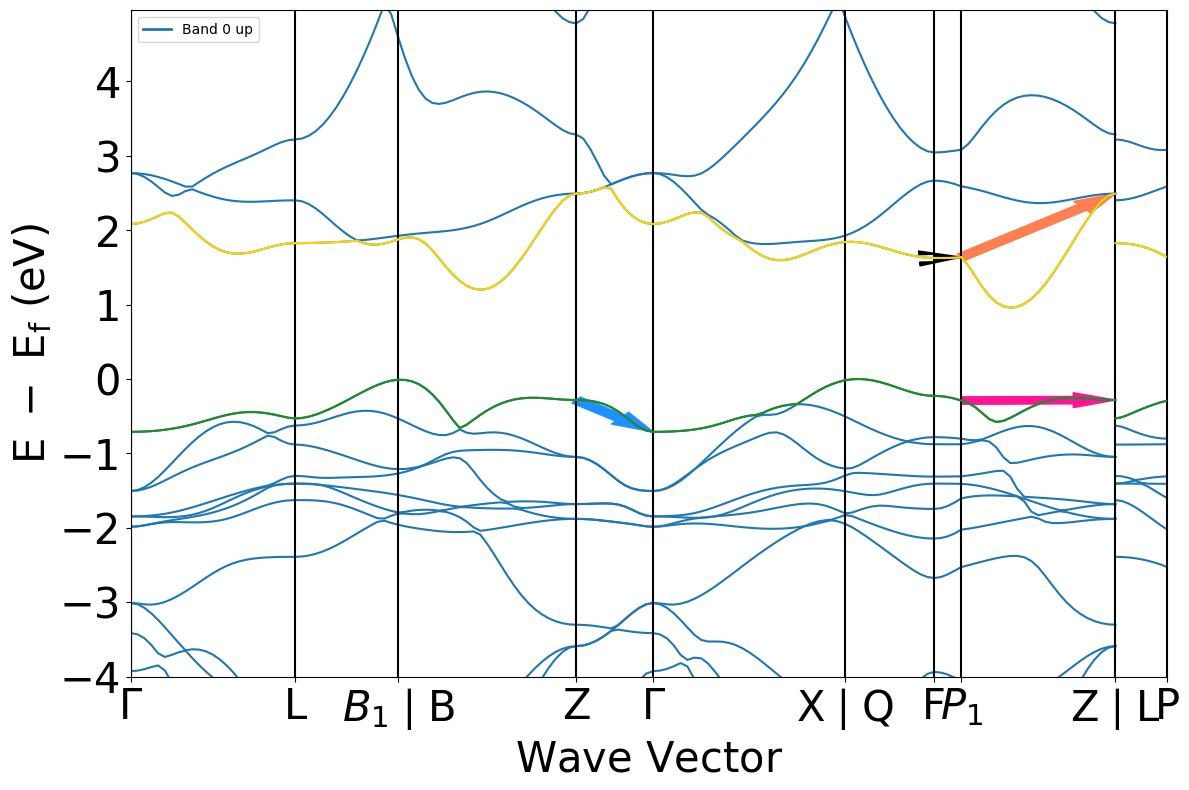

In [197]:
bsplot.get_plot()

for i in range(d):
    plt.plot(distances[i], energy['1'][i][vbm_band_index], 'forestgreen') 
    plt.plot(distances[i], energy['1'][i][cbm_band_index], 'gold')   

plt.arrow(x[idx_max_vbm], 
          y["1"][idx_max_vbm][21][0], 
          dx[idx_max_vbm], 
          dy_vbm[idx_max_vbm], 
          color='dodgerblue', width=0.1, head_width=0.2, length_includes_head=True)

plt.arrow(x[idx_min_vbm], 
          y["1"][idx_min_vbm][21][0], 
          dx[idx_min_vbm], 
          dy_vbm[idx_min_vbm], 
          color='deeppink', width=0.1, head_width=0.2, length_includes_head=True) 

plt.arrow(x[idx_max_cbm], 
          y["1"][idx_max_cbm][22][0], 
          dx[idx_max_cbm],
          dy_cbm[idx_max_cbm], 
          color='coral', width=0.1, head_width=0.2, length_includes_head=True)

plt.arrow(x[idx_min_cbm], 
          y["1"][idx_min_cbm][22][0], 
          dx[idx_min_cbm], 
          dy_cbm[idx_min_cbm], 
          color='black', width=0.1, head_width=0.2, length_includes_head=True)

d = len(distances)

plt.show()

Pour calculer les masses effectives en supposant une dispersion parabolique, on utilise la formule suivante :  

$$E(k) = \frac{\hbar^2k^2}{2m^*}$$ 

On trouve donc la masse effective comme ceci :  

$$m^* = \frac{\hbar^2(k_x^2 + k_y^2 + k_z^2)}{2E(k)}$$ 

In [200]:
hbarre = 6.62607015e-34/(2*np.pi)
eV = 1.6022e-19
A = 1e-10

Valence_k = el_bs.get_vbm()['kpoint'].frac_coords
Cond_k = el_bs.get_cbm()['kpoint'].frac_coords

Valence_energy = el_bs.get_vbm()['energy'] 
Cond_energy = el_bs.get_cbm()['energy'] 

Valence_masse = (hbarre**2*(Valence_k[0]**2+Valence_k[1]**2+Valence_k[2]**2))/(2*Valence_energy*eV*A**2)
Cond_masse = (hbarre**2*(Cond_k[0]**2+Cond_k[1]**2+Cond_k[2]**2))/(2*Cond_energy*eV*A**2)


print(f"La masse effective au sommet de la dernière bande de valence est de {Valence_masse} [kg].")
print(f"La masse effective à la base de la première bande de conduction est de {Cond_masse} [kg].")

La masse effective au sommet de la dernière bande de valence est de 4.487350317599023e-31 [kg].
La masse effective à la base de la première bande de conduction est de 5.576542710579682e-31 [kg].
